In [1]:
%cd ..

/home/oleg


In [2]:
# type: ignore

import typing
from typing import Any, cast

import gigaam
from gigaam.model import GigaAMASR
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import pandas as pd

from asr_eval.streaming.sender import StreamingAudioSender
from asr_eval.streaming.caller import transсribe_parallel
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import TranscriptionChunk, Signal
from asr_eval.streaming.evaluation import get_word_timings, get_partial_alignments, partial_alignment_diagram, visualize_history, remap_time

In [3]:
# type: ignore

dataset: Dataset = load_dataset('bond005/podlodka_speech')['test'].take(1)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
df = pd.DataFrame(list(dataset))

def get_streaming_sender(id: str, audio: dict[str, Any]) -> dict[str, Any]:
    return StreamingAudioSender(
        id=id,
        audio=np.int16(audio['array'] * 32768).tobytes(),
        array_len_per_sec=16_000 * 2,  # x2 because of the conversion float -> bytes
        real_time_interval_sec=1 / 5,
        speed_multiplier=1,
        # densify=True,
        verbose=True,
    )

df['id'] = df.audio.apply(lambda audio: audio['path'])
df['sender'] = df.apply(lambda row: get_streaming_sender(row.id, row.audio), axis=1)

In [4]:
# type: ignore

asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()
results = transсribe_parallel(asr=asr, senders=df.sender, n_threads=2, send_all_without_delays=True)
asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

Transcribing sound_test_0001.wav
Sending: id=sound_test_0001.wav, real 0.000..0.200, audio 0.200..0.200
Sending: id=sound_test_0001.wav, real 0.200..0.400, audio 0.400..0.400
Sending: id=sound_test_0001.wav, real 0.400..0.600, audio 0.600..0.600
Sending: id=sound_test_0001.wav, real 0.600..0.800, audio 0.800..0.800
Sending: id=sound_test_0001.wav, real 0.800..1.000, audio 1.000..1.000
Sending: id=sound_test_0001.wav, real 1.000..1.200, audio 1.200..1.200
Sending: id=sound_test_0001.wav, real 1.200..1.400, audio 1.400..1.400
Sending: id=sound_test_0001.wav, real 1.400..1.600, audio 1.600..1.600
Sending: id=sound_test_0001.wav, real 1.600..1.800, audio 1.800..1.800
Sending: id=sound_test_0001.wav, real 1.800..2.000, audio 2.000..2.000
Sending: id=sound_test_0001.wav, real 2.000..2.200, audio 2.200..2.200
Sending: id=sound_test_0001.wav, real 2.200..2.400, audio 2.400..2.400
Sending: id=sound_test_0001.wav, real 2.400..2.600, audio 2.600..2.600
Sending: id=sound_test_0001.wav, real 2.600.

In [5]:
# type: ignore

df['preds'] = [TranscriptionChunk.join(x) for x in results.values()]

jiwer.wer(reference=df['transcription'].tolist(), hypothesis=df['preds'].tolist())

0.46153846153846156

In [6]:
# TODO защита против нескольких транскрипций

In [7]:
sample = df.iloc[0] # type: ignore
sender = cast(StreamingAudioSender, sample.sender) # type: ignore
input_chunks = sender.history
output_chunks = results[sample['id']]
cutoffs = sender.get_send_times()

input_chunks_remapped, output_chunks_remapped = remap_time(cutoffs, input_chunks, output_chunks)

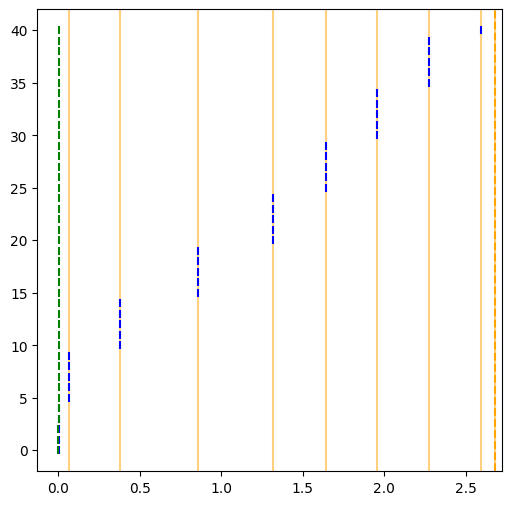

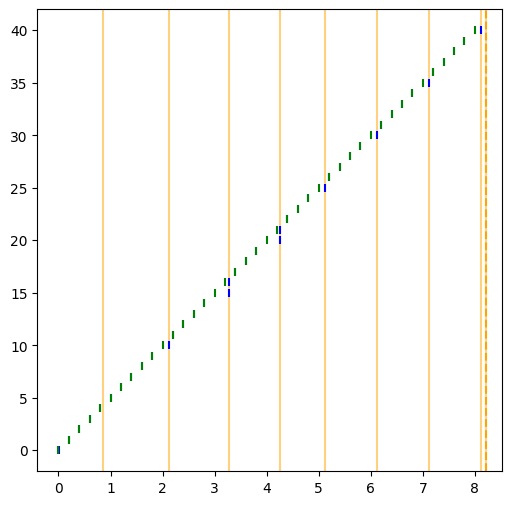

In [8]:
visualize_history(input_chunks, output_chunks)
visualize_history(input_chunks_remapped, output_chunks_remapped)

In [9]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [10]:
# type: ignore
sample = df.iloc[0]

text = sample['transcription']
text = text.lower().replace('ё', 'е').replace('-', ' ')
for char in ('.', ',', '!', '?', ';', ':', '"', '(', ')'):
    text = text.replace(char, '')

word_timings = get_word_timings(gigaam_model, sample['audio']['array'], text)

sender = cast(StreamingAudioSender, sample.sender)
input_chunks = sender.history
output_chunks = results[sample['id']]

display(input_chunks[:5])
display(output_chunks[:5])

[InputChunk(data=b'', start_time=0, end_time=0.2, put_timestamp=1750067832.8235223, get_timestamp=1750067832.8247125),
 InputChunk(data=b'', start_time=0.2, end_time=0.4, put_timestamp=1750067832.8235786, get_timestamp=1750067832.8247266),
 InputChunk(data=b'', start_time=0.4, end_time=0.6000000000000001, put_timestamp=1750067832.823614, get_timestamp=1750067832.8247342),
 InputChunk(data=b'', start_time=0.6000000000000001, end_time=0.8, put_timestamp=1750067832.8236408, get_timestamp=1750067832.8247664),
 InputChunk(data=b'', start_time=0.8, end_time=1.0, put_timestamp=1750067832.8236682, get_timestamp=1750067832.8247764)]

[OutputChunk(data=TranscriptionChunk(uid='4adcc697-90f7-4119-a42e-603e9d802daf', text=''), seconds_processed=1.0, put_timestamp=1750067832.8886592, get_timestamp=1750067832.8887844),
 OutputChunk(data=TranscriptionChunk(uid='4adcc697-90f7-4119-a42e-603e9d802daf', text=''), seconds_processed=2.0, put_timestamp=1750067833.2033706, get_timestamp=1750067833.2053356),
 OutputChunk(data=TranscriptionChunk(uid='4adcc697-90f7-4119-a42e-603e9d802daf', text='и поэтому'), seconds_processed=3.0, put_timestamp=1750067833.6782455, get_timestamp=1750067833.6784167),
 OutputChunk(data=TranscriptionChunk(uid='4adcc697-90f7-4119-a42e-603e9d802daf', text='и поэтому использовать их в повседневности не'), seconds_processed=4.0, put_timestamp=1750067834.142424, get_timestamp=1750067834.142766),
 OutputChunk(data=TranscriptionChunk(uid='4adcc697-90f7-4119-a42e-603e9d802daf', text='и поэтому использовать их в повседневности не получается'), seconds_processed=5.0, put_timestamp=1750067834.4666843, get_timestam

In [11]:
partial_alignments = get_partial_alignments(input_chunks, output_chunks, word_timings, processes=1) # type: ignore
partial_alignments[:5]

[PartialAlignment(alignment=MatchesList(matches=[(и, ), (поэтому, )], total_true_len=2, score=AlignmentScore(n_word_errors=2, n_correct=0, n_char_errors=8)), audio_seconds_sent=8.200000000000001, audio_seconds_processed=1.0, real_seconds_overhead=0.06401205062866211),
 PartialAlignment(alignment=MatchesList(matches=[(и, ), (поэтому, ), (использовать, ), (их, ), (в, )], total_true_len=5, score=AlignmentScore(n_word_errors=5, n_correct=0, n_char_errors=23)), audio_seconds_sent=8.200000000000001, audio_seconds_processed=2.0, real_seconds_overhead=0.3787233829498291),
 PartialAlignment(alignment=MatchesList(matches=[(и, и), (поэтому, поэтому), (использовать, ), (их, ), (в, ), (повседневности, ), (не, )], total_true_len=7, score=AlignmentScore(n_word_errors=5, n_correct=2, n_char_errors=31)), audio_seconds_sent=8.200000000000001, audio_seconds_processed=3.0, real_seconds_overhead=0.8535983562469482),
 PartialAlignment(alignment=MatchesList(matches=[(и, и), (поэтому, поэтому), (использовать,

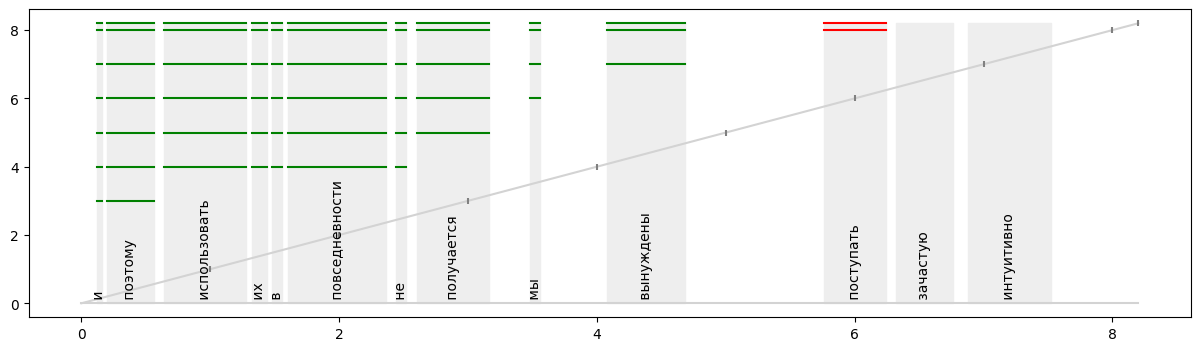

In [12]:
assert input_chunks[-1].end_time is not None

partial_alignment_diagram(
    partial_alignments,
    word_timings,
    audio_len=input_chunks[-1].end_time,  # TODO: may be not precise
    figsize=(15, 4),
    y_type='processed',
)

In [13]:
# print('Final transcription:', TranscriptionChunk.join(output_chunks))

# true_token_id_to_time_span = {
#     token.id: (start, end) for token, start, end in word_timings
# }

# last_word_end = [
#     max([
#         true_token_id_to_time_span[m.true[-1].id][-1]
#         for m in partial_al.alignment.matches
#         if m.status not in ('deletion', 'insertion')
#     ] or [0])
#     for partial_al in partial_alignments
# ]

# latency_sent = [p.audio_seconds_sent - end for p, end in zip(partial_alignments, last_word_end)]
# print(f'Average latency (sent): {np.mean(latency_sent):.1f} sec')

# latency_processed = [p.audio_seconds_processed - end for p, end in zip(partial_alignments, last_word_end)] # type: ignore
# print(f'Average latency (processed): {np.mean(latency_processed):.1f} sec') # type: ignore